# Customer segmentation using clustering an classification (Complicated)

https://archive.ics.uci.edu/ml/datasets/online+retail : 

이 데이터는 2010년 1월 20일 부터 2011년 9월 12일 까지의 기간동안 온라인 전자상거래 회사에서 발생한 transaction에 대한 내용입니다. 해당 회사는 UK-based non-store online 전자상거래 회사입니다.

이 데이터를 이용하여, 사용자의 행동을 분석합니다. 사용자의 행동을 분석하여, 사용자의 행동을 예측하는 모델을 만들겠습니다.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import datetime, nltk 
import matplotlib.cm as cm
import itertools

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML

# Plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

/Users/kakao/.pyenv/versions/3.6.3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 1. 데이터 로딩

In [3]:
# 유럽 데이터이기 때문에 인코딩을 다음과 같이 합니다.
df_initial = pd.read_csv('./inputs/e-commerce-data.csv', 
                         encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)
df_initial.head()

Dataframe dimensions: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


# 2. 데이터 전처리 (EDA 전, missing value 처리 등)

In [4]:
# InvoiceDate를 datetime 데이터 형태로 변형합니다. (나중 연산을 위하여)
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [5]:
# Null value의 카운트와 비율을 체크합니다.
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.
                         rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


25%의 결측치는 양이 너무 많습니다. 이 결측치의 값을 채워넣기보다는 제거하는 편이 낫습니다.

In [6]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (406829, 8)


In [7]:
# Null value를 제거한 후, 다시 한 번 null 값의 존재 유무를 체크합니다.
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.
                         rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


In [8]:
print('겹쳐지는 샘플의 수: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

겹쳐지는 샘플의 수: 5225


# 3. EDA 및 mining

- **InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- **StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- **Description**: Product (item) name. Nominal.
- **Quantity**: The quantities of each product (item) per transaction. Numeric.
- **InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated.
- **UnitPrice**: Unit price. Numeric, Product price per unit in sterling.
- **CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- **Country**: Country name. Nominal, the name of the country where each customer resides.

## 3.1 Country

각 나라에서 발생한 고유한 transaction에 대한 count를 구합니다.

In [9]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
temp.head()

,CustomerID,InvoiceNo,Country
0,12346,541431,United Kingdom
1,12346,C541433,United Kingdom
2,12347,537626,Iceland
3,12347,542237,Iceland
4,12347,549222,Iceland


In [10]:
# Transaction count에 대한 국가별 분포
countries = temp['Country'].value_counts()
countries

United Kingdom          19857
Germany                   603
France                    458
EIRE                      319
Belgium                   119
Spain                     105
Netherlands               101
Switzerland                71
Portugal                   70
Australia                  69
Italy                      55
Finland                    48
Sweden                     46
Norway                     40
Channel Islands            33
Japan                      28
Poland                     24
Denmark                    21
Cyprus                     20
Austria                    19
Malta                      10
Singapore                  10
Unspecified                 8
Iceland                     7
USA                         7
Israel                      6
Canada                      6
Greece                      6
European Community          5
Czech Republic              5
Lithuania                   4
United Arab Emirates        3
Saudi Arabia                2
Bahrain   

Plotly를 활용한 시각화

In [11]:
data = dict(type='choropleth',
            locations = countries.index,
            locationmode = 'country names', 
            z = countries,
            text = countries.index, 
            colorbar = {'title':'Order nb.'},
            colorscale=[[0, 'rgb(224,255,255)'],
                        [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
                        [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
                        [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
                        [1, 'rgb(227,26,28)']],    
            reversescale = False)

layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

## 3.2 Customers and products



In [12]:
df_initial.shape

(401604, 8)

Users의 수와 products의 수를 알아보겠습니다.

In [13]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], 
             columns = ['products', 'transactions', 'customers'], 
             index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


In [14]:
# 특정 유저의 transaction 이력
df_initial[df_initial.InvoiceNo == '581180']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
535004,581180,23497,CLASSIC CHROME BICYCLE BELL,12,2011-12-07 15:52:00,1.45,12347,Iceland
535005,581180,23552,BICYCLE PUNCTURE REPAIR KIT,6,2011-12-07 15:52:00,2.08,12347,Iceland
535006,581180,21064,BOOM BOX SPEAKER BOYS,24,2011-12-07 15:52:00,1.25,12347,Iceland
535007,581180,84625A,PINK NEW BAROQUECANDLESTICK CANDLE,24,2011-12-07 15:52:00,0.85,12347,Iceland
535008,581180,21731,RED TOADSTOOL LED NIGHT LIGHT,24,2011-12-07 15:52:00,1.65,12347,Iceland
535009,581180,23084,RABBIT NIGHT LIGHT,24,2011-12-07 15:52:00,1.79,12347,Iceland
535010,581180,20719,WOODLAND CHARLOTTE BAG,10,2011-12-07 15:52:00,0.85,12347,Iceland
535011,581180,21265,PINK GOOSE FEATHER TREE 60CM,12,2011-12-07 15:52:00,1.95,12347,Iceland
535012,581180,23271,CHRISTMAS TABLE SILVER CANDLE SPIKE,16,2011-12-07 15:52:00,0.83,12347,Iceland
535013,581180,23506,MINI PLAYING CARDS SPACEBOY,20,2011-12-07 15:52:00,0.42,12347,Iceland


개별 Transaction에서 구입한 각기 다른 Item의 수를 구하도록 합니다.

In [15]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.sort_values('CustomerID').head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


해당 정보를 이용하여 얻을 수 있는 것들 :
- **InvoiceNo**에 C가 붙어있음을 통해서, 해당 transaction이 취소된 것을 알 수 있습니다.
- 1개만 구입한 사용자가 존재하는 것을 알 수 있습니다. (ex, 12346)
- 각 transaction에서 많은 items를 주문한 사용자가 있음을 알 수 있습니다. (ex, 12347)

## 3.3 Cancelling orders

Cancel order에 대한 transaction

In [16]:
nb_products_per_basket['order_canceled'] = \
    nb_products_per_basket['InvoiceNo'].apply(lambda x: int('C' in x))
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


In [17]:
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('취소된 주문의 비율: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

취소된 주문의 비율: 3654/22190 (16.47%) 


취소 비율이 16%이면 높은 편입니다.

In [18]:
df_initial.sort_values('CustomerID').head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


취소내역과, 구입 내역이 1:1인지를 확인합니다. Quantity를 보면 -1이 곱해지는 것을 볼 수 있습니다.
 - 예외발생경우 : 2010년 1월 이전에 구입한 상품에 대한 취소 건수 (예측 가능)

In [19]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object


Discount의 경우가 발생

In [20]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object


In [21]:
# 바로 이 경우가 예측 가능한 경우입니다. 즉 이전의 구매목록이 없고 취소 내역만 있는 경우입니다.
df_initial[(df_initial['CustomerID'] == '15311')
           & (df_initial['Description'] == 'SET OF 3 COLOURED  FLYING DUCKS')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


In [22]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = []
doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': 
        continue  
    # 구매시기가 취소시기보다 먼저여야 합니다.
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity'] > 0)].copy()
    # 구입 transaction이 없는 취소
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    # 구입 transaction이 있는 취소
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    # 취소 transaction보다 구매 transaction의 수가 큰 경우
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: 
                continue
            # 취소 transaction보다 수량이 더 많은 구매 transaction이 있으면 빼준다.
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

- `entry_to_remove` : 대응되는 구입 transaction이 없는 취소 내역
- `doubtfull_entry` : 대응되는 구입 transaction이 있는 취소 내역(단, 같은 quantity가 최소한 1개 이상 있는)

In [23]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 1226


취소 내역은 모두 삭제

In [24]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)

df_cleaned.shape

(392857, 9)

## 3.4 StockCode

**StockCode** 는 D(discount) 및 문자, 그리고 숫자형 데이터를 모두 포함하고 있습니다. 문자로 이루어진 경우를 찾아봅니다.

In [25]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [26]:
for code in list_special_codes:
    print("{:<15} : {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            : POSTAGE                       
D               : Discount                      
C2              : CARRIAGE                      
M               : Manual                        
BANK CHARGES    : Bank Charges                  
PADS            : PADS TO MATCH ALL CUSHIONS    
DOT             : DOTCOM POSTAGE                


## 3.5 Basket Price
가격에 대해서 mining을 합니다. 한 번의 transaction에서 Customer가 구한 상품들에 대한 전체 price를 계산합니다.

먼저, 각 StockCode에 대한 Total price 변수를 생성하겠습니다.

In [27]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID').head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7


Transaction에 대한 basket price 변수를 생성하겠습니다.

In [28]:
# Basket price
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
basket_price.head()

,CustomerID,InvoiceNo,Basket Price
0,12346,541431,0.00
1,12347,537626,711.79
2,12347,542237,475.39
3,12347,549222,636.25
4,12347,556201,382.52


In [29]:
# 1번의 transaction에서의 평균 구매 일시(average of invoice date)를 구합니다.
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
basket_price.head()

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
0,12346,541431,0.00,2011-01-18 10:01:00.000000000
1,12347,537626,711.79,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,2011-06-09 13:01:00.000000256


In [30]:
# Basket price가 0보다 큰 경우만 선택합니다.
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID').head()

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,2011-08-02 08:48:00.000000000


Basket price의 range를 나눕니다.

In [31]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []

for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

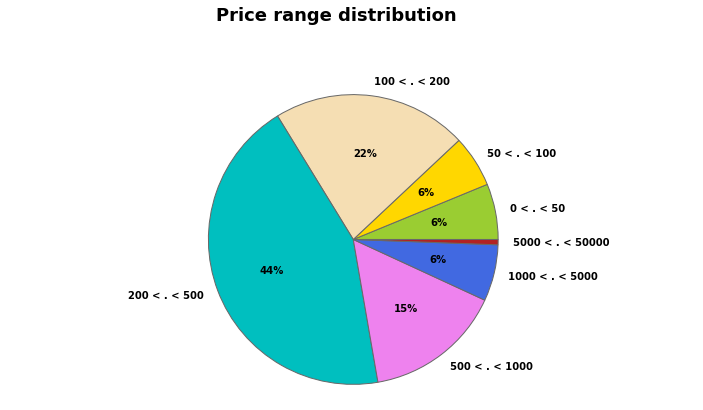

In [32]:
plt.rc('font', weight='bold')

f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{} < . < {}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Price range distribution ", ha='center', fontsize = 18);

65% 정도의 고객이 200유로 이상의 돈을 사용하고 있습니다.

## 3.6 Product categories
**Description** 를 이용하여 product별 category를 만들어 보겠습니다.

___
**NLTK**

품사 및 pos tagging : https://konlpy-ko.readthedocs.io/ko/v0.4.3/morph/

In [33]:
is_noun = lambda pos: pos[:2] == 'NN'

from nltk.tokenize import sent_tokenize, word_tokenize

EXAMPLE_TEXT = "Hello Mr. Smith, how are you doing today? The weather is great, and Python is awesome."

# Sentence parsing
print(sent_tokenize(EXAMPLE_TEXT))
# Word parsing
print(word_tokenize(EXAMPLE_TEXT))

['Hello Mr. Smith, how are you doing today?', 'The weather is great, and Python is awesome.']
['Hello', 'Mr.', 'Smith', ',', 'how', 'are', 'you', 'doing', 'today', '?', 'The', 'weather', 'is', 'great', ',', 'and', 'Python', 'is', 'awesome', '.']


In [34]:
# 품사 태깅
print(nltk.pos_tag(word_tokenize(EXAMPLE_TEXT)))

[('Hello', 'NNP'), ('Mr.', 'NNP'), ('Smith', 'NNP'), (',', ','), ('how', 'WRB'), ('are', 'VBP'), ('you', 'PRP'), ('doing', 'VBG'), ('today', 'NN'), ('?', '.'), ('The', 'DT'), ('weather', 'NN'), ('is', 'VBZ'), ('great', 'JJ'), (',', ','), ('and', 'CC'), ('Python', 'NNP'), ('is', 'VBZ'), ('awesome', 'JJ'), ('.', '.')]


In [35]:
# 명사만 추출
print([word for (word, pos) in nltk.pos_tag(word_tokenize(EXAMPLE_TEXT)) if is_noun(pos)])

['Hello', 'Mr.', 'Smith', 'today', 'weather', 'Python']


Stemming : https://devtimes.com/bigdata/2019/03/20/nlp-preprocessing/

In [36]:
stemmer = nltk.stem.SnowballStemmer("english")
stemmer.stem('girls')

'girl'

---

### 3.6.1 Products Description
- `keywords`: Description에서 추출된 모든 단어들
- `keywords_roots`: 어근(root)와 root와 association된 단어들
- `count_keywords`: 단어가 몇 번 나왔는지를 체크

In [37]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # 어근
    keywords_select = dict()  # 어근과 연결되 연결된 단어들
    category_keys   = []  # 몇 개의 category key가 있는지 체크하기 위하여
    count_keywords  = dict()
    icount = 0
    for s in dataframe['Description']:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower()
            racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k
                    min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef  # 어근 찾기 (가장 짧음)
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Number of keywords in variable '{}': {}".format('Description', len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [38]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

In [39]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Number of keywords in variable 'Description': 1483


In [40]:
keywords[:10]

['heart',
 'holder',
 'metal',
 'lantern',
 'cream',
 'cupid',
 'coat',
 'hanger',
 'union',
 'flag']

In [41]:
keywords_roots['heart']

{'heart', 'hearts'}

In [42]:
keywords_select['heart']

'heart'

가장 빈도수가 높은 단어를 찾습니다.

In [43]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

In [44]:
list_products[:10]

[['heart', 267],
 ['vintage', 211],
 ['set', 206],
 ['pink', 189],
 ['bag', 165],
 ['box', 155],
 ['glass', 149],
 ['christmas', 137],
 ['design', 128],
 ['candle', 121]]

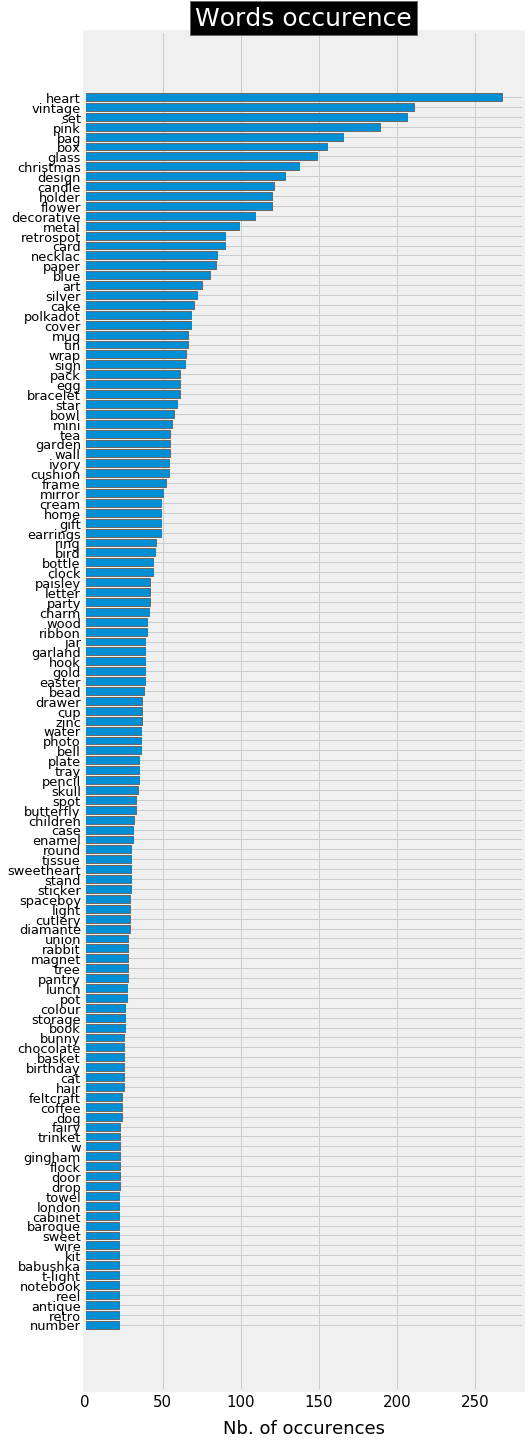

In [45]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

### 3.6.2 Defining product categories 

의미없는 단어는 지우도록 하겠습니다.

In [46]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])

list_products.sort(key = lambda x:x[1], reverse = True)
list_products[:10]

[['heart', 267],
 ['vintage', 211],
 ['set', 206],
 ['bag', 165],
 ['box', 155],
 ['glass', 149],
 ['christmas', 137],
 ['design', 128],
 ['candle', 121],
 ['holder', 120]]

### 3.6.3 Data encoding

|   | word 1  |  ...  | word j  | ...  | word N  |
|:-:|---|---|---|---|---|
| product 1  | $a_{1,1}$  |     |   |   | $a_{1,N}$  |
| ...        |            |     | ...  |   |   |
|product i   |    ...     |     | $a_{i,j}$    |   | ...  |
|...         |            |     |  ... |   |   |
| product M  | $a_{M,1}$  |     |   |   | $a_{M,N}$   |

$a_ {i, j}$ : 
 - 1 : product $i$의 description이 word $j$를 포함
 - 0 : product $i$의 description이 word $j$를 포함하지 않을 때

In [47]:
list_prods = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), list_prods))

상품의 description을 embedding vector로 만들었습니다. 여기에 상품 unit price에 따른 Range를 추가해봅니다. 왜냐하면, 상품의 가격과 상품의 description을 연결시켜보면 더 좋은 정보를 얻을 수 있기 때문입니다.

In [48]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(list_prods):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [49]:
print("{:<8} {:<20} \n".format('Range', 'Product의 수') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

Range    Product의 수           
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


In [50]:
print(X.shape)
X.head()

(3878, 199)


,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,lace,jewel,wallet,point,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### 3.6.3 Creating clusters of products

이젠, 상품의 cluster를 구해보도록 하겠습니다. 사실 binary encoding으로 이루어진 데이터에서 거리를 측정하기 위해서는 *Hamming's metric* 을 이용해야 합니다. 하지만 여기서는 *Kmeans* 알고리즘을 사용하도록 하겠습니다.

그리고 최적의 클러스터의 숫자를 구하기 위해서, silhouette score를 사용하겠습니다.

In [51]:
matrix = X.as_matrix()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10071681758064248
For n_clusters = 4 The average silhouette_score is : 0.12609893747265383
For n_clusters = 5 The average silhouette_score is : 0.14520347938271963
For n_clusters = 6 The average silhouette_score is : 0.1449025743560329
For n_clusters = 7 The average silhouette_score is : 0.14632523950923132
For n_clusters = 8 The average silhouette_score is : 0.1491015285489303
For n_clusters = 9 The average silhouette_score is : 0.14904187793989918


클러스터의 숫자는 5를 선택하여 silhouette score의 평균이 일정 수준보다 낮아지면 학습을 멈추도록 합니다.

In [52]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.1466257603527048


### 3.6.4  Characterizing the content of clusters

In [53]:
pd.Series(clusters).value_counts()

0    1009
2     964
1     762
3     673
4     470
dtype: int64

> **Silhouette intra-cluster score** : [sklearn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

In [54]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        y_lower = y_upper + 10  

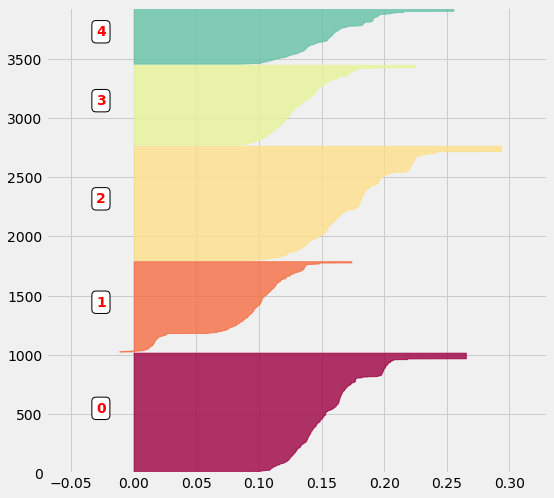

In [55]:
sample_silhouette_values = silhouette_samples(matrix, clusters)
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

> **Word Cloud**

In [56]:
_list = pd.DataFrame(list_prods)
list_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    list_cluster = _list.loc[clusters == i]
    for word in list_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(list_cluster.loc[:, 0].str.contains(word.upper()))

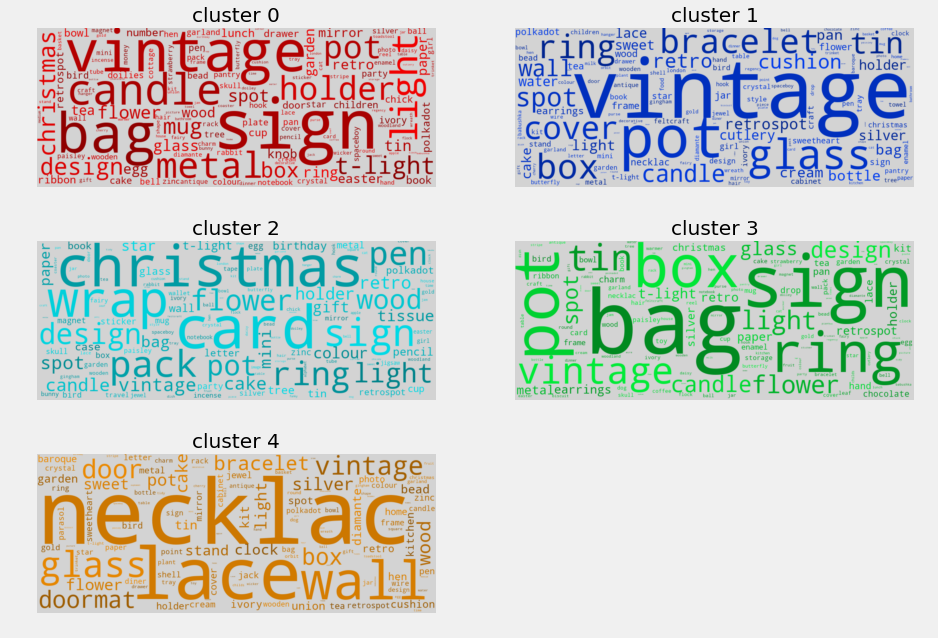

In [57]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster {}'.format(increment-1))

fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i]
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)            

> **Principal Component Analysis**

In [58]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

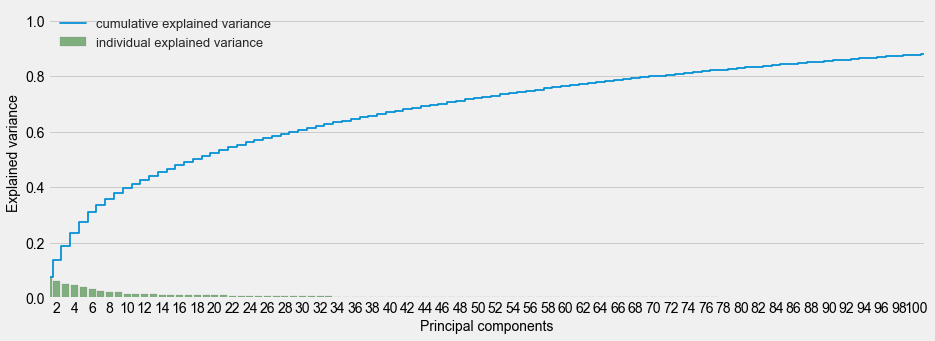

In [59]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

100개 이상이 되어야 전체 분산의 90%를 설명할 수 있습니다. 하지만 시각화를 위해서 50개만 선택해보겠습니다.

In [60]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

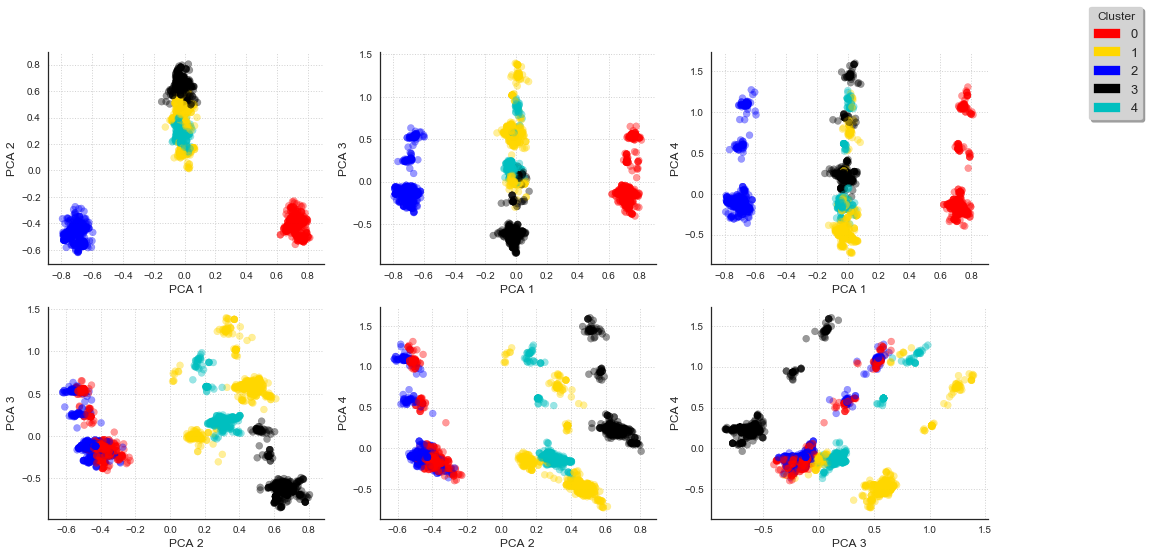

In [61]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

## 3.7 Customer categories

In [62]:
corresp = dict()
for key, val in zip (list_prods, clusters):
    corresp[key] = val 

df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,categ_product
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,3
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,1


### 3.7.1 Grouping products

**categ_N** (with $ N \in [0: 4]$)을 생성하겠습니다. 각각은 해당 Transaction의 구매금액에 대한 category의 one_hot이라고 생각하면 됩니다.

In [63]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)

df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']].head()

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,3,0.0,0.00,0.0,15.3,0.0
1,536365,WHITE METAL LANTERN,1,0.0,20.34,0.0,0.0,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,1,0.0,22.00,0.0,0.0,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,1,0.0,20.34,0.0,0.0,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,1,0.0,20.34,0.0,0.0,0.0


데이터를 하나로 모으도록 하겠습니다.

In [64]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

In [65]:
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 

In [66]:
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True).head()

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,187.2,293.35,23.40,83.40,124.44,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,130.5,207.45,84.34,53.10,0.00,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,330.9,153.25,81.00,71.10,0.00,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,74.4,168.76,41.40,78.06,19.90,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,109.7,196.41,61.30,119.70,97.80,2011-08-02 08:48:00.000000000


### 3.7.2 Separation of data over time

모델링의 목적은 사용자의 행동을 분석하여, 그 다음 사용자의 행동을 예측하는 것입니다. 따라서, 현 데이터의 10개월 치의 데이터만 학습에 사용하고, 2개월 치의 데이터를 테스트에 사용하겠습니다.

In [67]:
print(basket_price['InvoiceDate'].min(), basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 2011-12-09 12:50:00


In [68]:
set_entrainement = basket_price[basket_price['InvoiceDate'] < datetime.date(2011,10,1)]
set_test         = basket_price[basket_price['InvoiceDate'] >= datetime.date(2011,10,1)]
basket_price = set_entrainement.copy(deep = True)

In [69]:
basket_price.head()

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,187.2,293.35,23.40,83.40,124.44,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,130.5,207.45,84.34,53.10,0.00,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,330.9,153.25,81.00,71.10,0.00,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,74.4,168.76,41.40,78.06,19.90,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,109.7,196.41,61.30,119.70,97.80,2011-08-02 08:48:00.000000000


### 3.7.3 Consumer Order

In [70]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])

for i in range(5):
    col = 'categ_{}'.format(i)
    # 각 유저의 Basket_price sum 대비 각 카테고리별로 얼마의 돈을 사용하였는가를 비율로 나타냅니다.
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

In [71]:
transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True).head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,5,382.52,711.79,558.172000,2790.86,29.836681,36.519926,10.442659,14.524555,8.676179
1,12348,4,227.44,892.80,449.310000,1797.24,41.953217,20.030714,38.016069,0.000000,0.000000
2,12350,1,334.40,334.40,334.400000,334.40,48.444976,11.961722,11.692584,27.900718,0.000000
3,12352,6,144.35,840.30,345.663333,2073.98,12.892120,68.944734,0.491808,3.370331,14.301006
4,12353,1,89.00,89.00,89.000000,89.00,13.033708,44.719101,0.000000,19.887640,22.359551


** FirstPurchase **, ** LastPurchase ** 를 정의합니다.

In [72]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,5,382.52,711.79,558.172000,2790.86,29.836681,36.519926,10.442659,14.524555,8.676179,59,297
1,12348,4,227.44,892.80,449.310000,1797.24,41.953217,20.030714,38.016069,0.000000,0.000000,5,288
2,12350,1,334.40,334.40,334.400000,334.40,48.444976,11.961722,11.692584,27.900718,0.000000,240,240
3,12352,6,144.35,840.30,345.663333,2073.98,12.892120,68.944734,0.491808,3.370331,14.301006,2,226
4,12353,1,89.00,89.00,89.000000,89.00,13.033708,44.719101,0.000000,19.887640,22.359551,134,134


1개의 Transaction만 가지고 있는 사용자들은 전체의 40% 정도입니다.

In [73]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("{:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

1445/3608  (40.05%)


## 3.8 Creation of customers categories

Customer를 카테고리로 나누어 보겠습니다.

### 3.8.1 Data encoding

In [74]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']

selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].as_matrix()

In [75]:
matrix[:1]

array([[  5.        , 382.52      , 711.79      , 558.172     ,
         29.83668117,  36.51992576,  10.44265925,  14.52455516,
          8.67617867]])

In [76]:
scaler = StandardScaler()
scaler.fit(matrix)
scaled_matrix = scaler.transform(matrix)

In [77]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

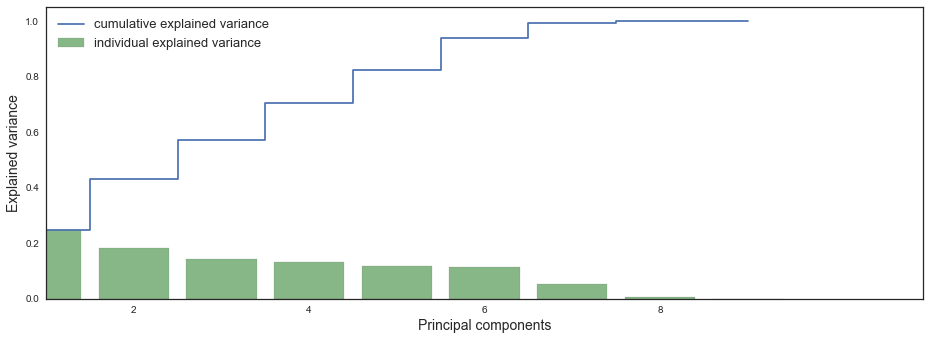

In [78]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

### 3.8.2 Creation of customer categories

Silhouette score를 사용하여 best score를 찾습니다.

In [79]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouett score: {:<.3f}'.format(silhouette_avg))

silhouett score: 0.213


In [80]:
# 각 클러스터에 속한 사용자의 수를 나타냅니다.
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['num_clients']).T

,1,3,2,10,5,9,0,7,8,4,6
num_clients,1440,476,428,350,294,232,187,170,12,11,8


> **Report via the PCA**

In [81]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

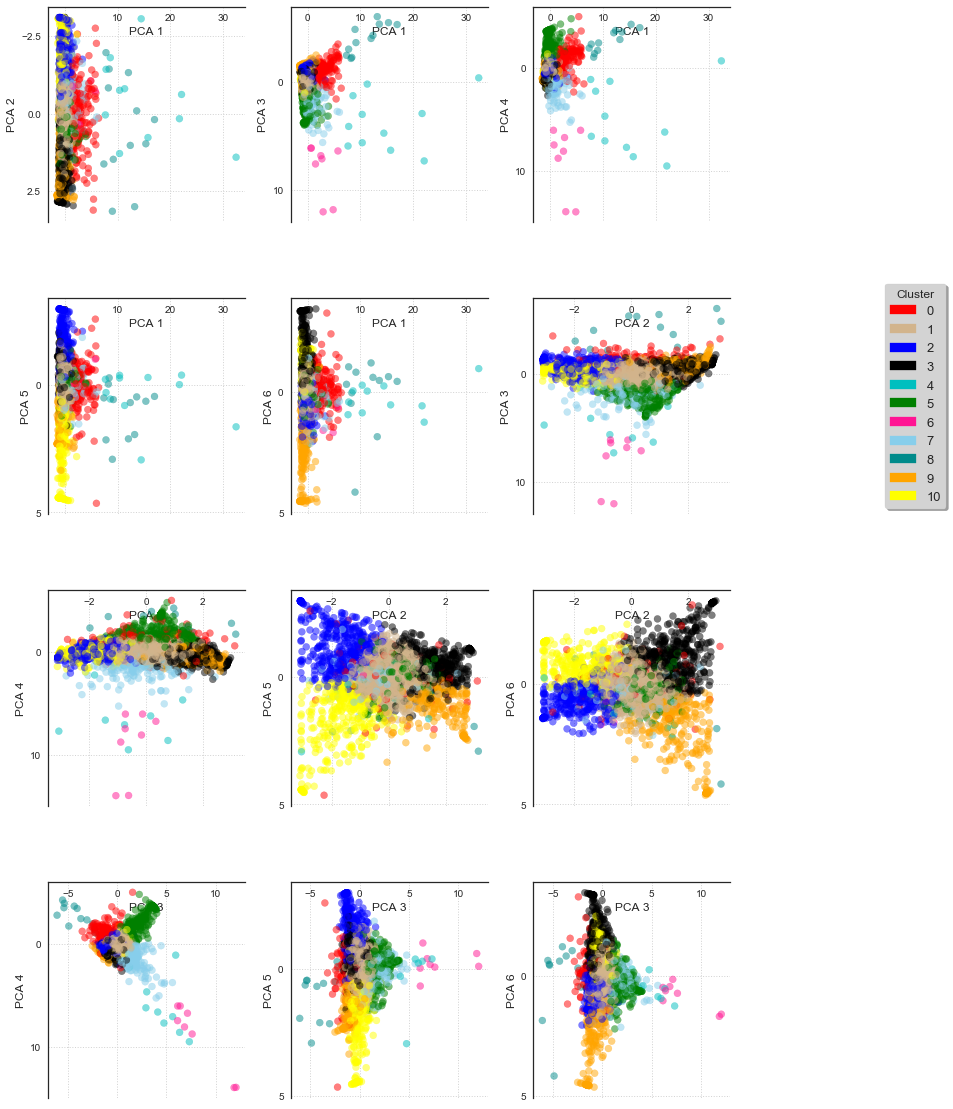

In [82]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        

comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

> ** Silhouette Score **

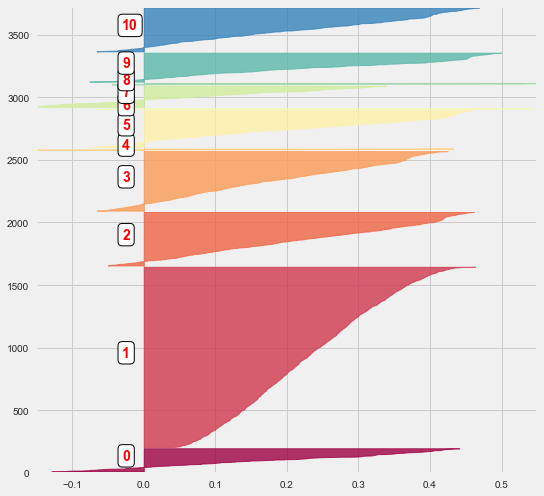

In [83]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

**Customers morphotype**

각 클러스터가 disjoint 한지 알아보려고 합니다. 각 클러스터에 있는 사용자의 특징을 이해해야 합니다.

In [84]:
selected_customers.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,5,382.52,711.79,558.172000,2790.86,29.836681,36.519926,10.442659,14.524555,8.676179,59,297
1,12348,4,227.44,892.80,449.310000,1797.24,41.953217,20.030714,38.016069,0.000000,0.000000,5,288
2,12350,1,334.40,334.40,334.400000,334.40,48.444976,11.961722,11.692584,27.900718,0.000000,240,240
3,12352,6,144.35,840.30,345.663333,2073.98,12.892120,68.944734,0.491808,3.370331,14.301006,2,226
4,12353,1,89.00,89.00,89.000000,89.00,13.033708,44.719101,0.000000,19.887640,22.359551,134,134


In [85]:
selected_customers.loc[:, 'cluster'] = clusters_clients

In [86]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])

In [87]:
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3608


In [88]:
list_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    list_index.append(merged_df[merged_df[column] > 45].index.values[0])

list_index_reordered = list_index
list_index_reordered += [ s for s in merged_df.index if s not in list_index]

merged_df = merged_df.reindex(index = list_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,3.0,2.449580,216.744496,334.344750,272.473924,679.057838,56.680495,11.322272,13.147510,12.766739,6.086111,476
1,2.0,2.203271,211.724019,355.498621,273.988479,688.517991,10.695659,59.785024,5.178139,11.515413,12.848634,428
2,9.0,2.232759,193.033448,320.214698,247.738855,596.108319,18.075663,7.851373,57.478589,11.099433,5.494942,232
3,5.0,2.591837,212.200306,382.740612,293.605734,824.346429,15.142753,9.628434,7.006628,60.856848,7.365337,294
4,10.0,2.502857,192.872803,312.765600,246.358670,637.946117,11.688894,19.315748,5.298483,11.562019,52.150979,350
5,1.0,3.169444,218.600653,453.334431,327.553404,1051.668299,25.692828,23.782665,13.860225,22.346484,14.325874,1440
6,0.0,1.780749,1036.407273,1406.419898,1208.575796,2295.588027,26.442669,26.240813,12.319619,21.236023,13.761236,187
7,8.0,1.666667,3480.920833,3966.812500,3700.139306,5949.600000,20.102624,25.406109,22.890736,13.322062,18.278470,12
8,7.0,17.300000,85.856235,1371.904824,512.325338,8577.259235,24.266303,23.409515,12.046817,24.409434,15.886363,170
9,6.0,87.125000,20.862500,2643.812500,456.526689,37313.235000,25.165035,22.340235,11.477885,24.604929,16.434535,8


**Customers morphology**

(https://www.kaggle.com/yassineghouzam/don-t-know-why-employees-leave-read-this) 참고

In [89]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid(False)
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)


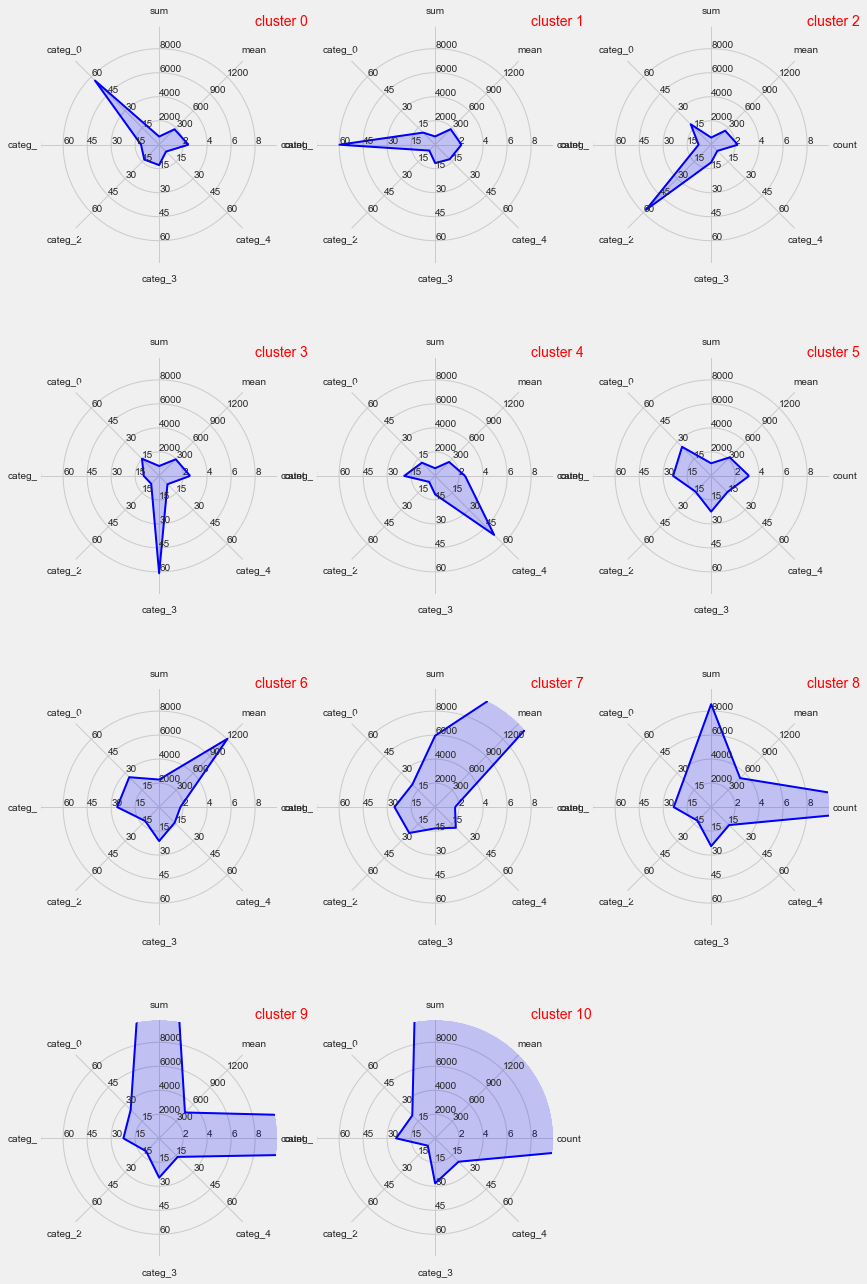

In [90]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster {}'.format(index[ind]), color = 'r')
    ind += 1 

## 4. Classification of customers

In [91]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))
        

In [92]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

In [93]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8, random_state=42)

In [94]:
X_train.head()

,mean,categ_0,categ_1,categ_2,categ_3,categ_4
2530,34.000,0.000000,0.000000,0.000000,0.000000,100.000000
1113,480.910,28.329625,23.601090,13.437026,16.645526,17.986733
2893,420.595,19.858772,26.545727,16.801198,13.279996,23.514307
790,388.115,9.043711,42.191103,6.258454,18.937686,23.569045
3006,295.628,30.749455,17.559230,24.243306,21.602825,5.845184


In [95]:
Y_train.head()

2530    10
1113     1
2893     1
790      2
3006     1
Name: cluster, dtype: int32

### 4.1 Support Vector Machine Classifier (SVC)
#### 4.1.1 학습

In [96]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

In [97]:
svc.grid_fit(X = X_train, Y = Y_train)

In [98]:
svc.grid_predict(X_test, Y_test)

Precision: 83.24 % 


#### 4.1.2 성능평가

성능평가를 위해 Confusion matrix를 사용하겠습니다.

In [99]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


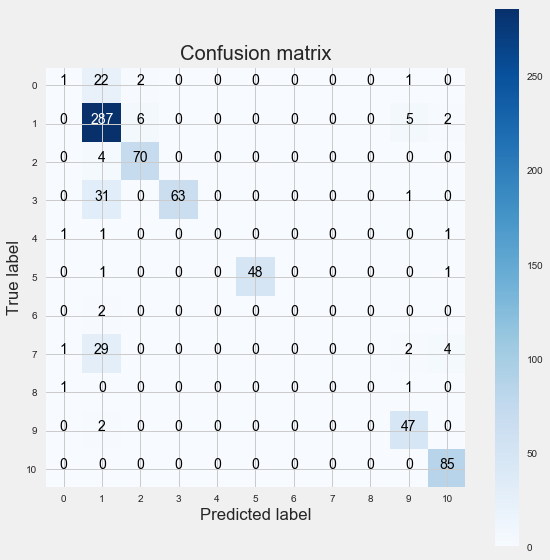

In [100]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

### 4.2 Random Forest

In [101]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 90.03 % 
